## Al final del analisis de datos se encuentra el plan de trabajo

# 📈 Predicción de Tasa de Cancelación de Clientes para Interconnect



## Introducción

El operador de telecomunicaciones Interconnect busca anticiparse a la cancelación de sus clientes. Con esta previsión, pretende implementar estrategias efectivas de retención, como ofertas personalizadas, códigos promocionales y opciones de planes especiales. Este proyecto se centra en construir un modelo de machine learning que permita pronosticar la tasa de cancelación de clientes, basándonos en un conjunto de datos que contiene información detallada sobre contratos, servicios y datos personales de los clientes de Interconnect.

### Objetivos del Proyecto

1. **Predecir la Cancelación de Clientes**: Utilizar técnicas avanzadas de machine learning para identificar patrones de comportamiento que preceden la cancelación.
2. **Mejorar la Retención de Clientes**: Facilitar al equipo de marketing la identificación temprana de clientes en riesgo, permitiendo la intervención oportuna mediante promociones y ajustes de planes.
3. **Optimizar la Toma de Decisiones**: Proporcionar una herramienta predictiva que permita a Interconnect asignar recursos de manera eficiente y priorizar la retención de clientes valiosos.

### Estructura del Notebook

1. **Preparación de Datos**: Limpieza y procesamiento de los datos para asegurar su calidad.
2. **Análisis Exploratorio de Datos (EDA)**: Visualización y análisis para identificar patrones y correlaciones.
3. **Ingeniería de Características**: Creación de nuevas variables para mejorar el rendimiento predictivo.
4. **Entrenamiento y Validación del Modelo**: Prueba de diferentes algoritmos de machine learning y ajuste de hiperparámetros para seleccionar el modelo óptimo.
5. **Evaluación del Modelo**: Análisis de las métricas para validar la efectividad del modelo.
6. **Resultados y Recomendaciones**: Interpretación de los resultados y propuestas para estrategias de retención de clientes basadas en las predicciones obtenidas.

Este notebook proporcionará una guía completa para la predicción de cancelación de clientes en Interconnect, desde el análisis inicial hasta la recomendación final. ¡Comencemos!

### Enfoque y Métricas

Este proyecto se abordará en varias etapas, desde la recolección y preparación de datos hasta el modelado y la evaluación. El objetivo es lograr un modelo predictivo robusto, utilizando como métrica principal el **AUC-ROC** (Area Under the Receiver Operating Characteristic Curve) y, como métrica adicional, la **exactitud**. Una puntuación AUC-ROC superior a 0.88 se considera ideal para el éxito de este proyecto.

---

## 1.- Exploración de datos

In [1]:
# Importa librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder

In [2]:
# Función para cargar datos con manejo de errores
def load_data(file_name):
    file_path = f"files/datasets/input/{file_name}"
    try:
        data = pd.read_csv(file_path)
        print(f"Data loaded successfully from {file_path}")
        return data
    except Exception as e:
        print(f"Error: File {file_path} not found.")
        return None

In [3]:
# Cargar cada archivo CSV en un DataFrame
contract_data = pd.read_csv('./Data/contract.csv')
personal_data = pd.read_csv('./Data/personal.csv')
internet_data = pd.read_csv('./Data/internet.csv')
phone_data = pd.read_csv('./Data/phone.csv')

In [4]:
# Verifica si los datos se cargaron correctamente
if contract_data is not None and personal_data is not None and internet_data is not None and phone_data is not None:
    # Une los datos en un solo DataFrame
    merged_data = pd.merge(contract_data, personal_data, on='customerID', how='inner')
    merged_data = pd.merge(merged_data, internet_data, on='customerID', how='left')
    merged_data = pd.merge(merged_data, phone_data, on='customerID', how='left')

### Descripción de los Datos

El análisis se llevará a cabo utilizando cuatro conjuntos de datos proporcionados por Interconnect:

- **`contract.csv`**: Información sobre el contrato del cliente, incluyendo duración, tipo de contrato y método de pago.
- **`personal.csv`**: Datos demográficos del cliente, como edad, género y estado civil.
- **`internet.csv`**: Información sobre el tipo de conexión a Internet y servicios adicionales contratados.
- **`phone.csv`**: Detalles sobre los servicios de telefonía fija y opciones de multilínea.

Cada archivo incluye una columna de ID única (`customerID`) que nos permitirá fusionar y analizar la información de manera integral.

In [5]:
# Muestra información sobre los datos cargados
display(merged_data.info)

<bound method DataFrame.info of       customerID   BeginDate              EndDate            Type  \
0     7590-VHVEG  2020-01-01                   No  Month-to-month   
1     5575-GNVDE  2017-04-01                   No        One year   
2     3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3     7795-CFOCW  2016-05-01                   No        One year   
4     9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   
...          ...         ...                  ...             ...   
7038  6840-RESVB  2018-02-01                   No        One year   
7039  2234-XADUH  2014-02-01                   No        One year   
7040  4801-JZAZL  2019-03-01                   No  Month-to-month   
7041  8361-LTMKD  2019-07-01  2019-11-01 00:00:00  Month-to-month   
7042  3186-AJIEK  2014-08-01                   No        Two year   

     PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0                 Yes           Electronic check          

In [6]:
display(merged_data.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


## 2.- Preprocesamiento de datos

In [7]:
# Manejo de fechas

# Reemplazar los valores 'No' en 'EndDate' con la fecha de hoy
today = pd.Timestamp('today').normalize()
merged_data.loc[merged_data['EndDate'] == 'No', 'EndDate'] = today

# Rellena valores NaN en 'EndDate' con la fecha de hoy
merged_data['EndDate'] = merged_data['EndDate'].fillna(today)

In [8]:
# Convierte 'EndDate' a datetime
merged_data['EndDate'] = pd.to_datetime(merged_data['EndDate'])

# Convierte 'BeginDate' a datetime
merged_data['BeginDate'] = pd.to_datetime(merged_data['BeginDate'])

merged_data['ContractDuration'] = (merged_data['EndDate'] - merged_data['BeginDate']).dt.days / 30


In [9]:
# Crea una nueva columna 'Churn' indicando si el cliente ha cancelado o no
merged_data['Churn'] = (pd.to_datetime(merged_data['EndDate']).dt.normalize() < today).astype(int)

# Reorganiza las columnas para que 'Churn' sea la cuarta columna
columns = list(merged_data.columns)
columns.remove('Churn')
columns.insert(3, 'Churn')
merged_data = merged_data[columns]

In [10]:
# Manejo de valores faltantes

# Rellena valores faltantes en 'MultipleLines' con 'No'
merged_data['MultipleLines'] = merged_data['MultipleLines'].fillna('No') 

# Convierte a numérico y manejar errores
merged_data['TotalCharges'] = pd.to_numeric(merged_data['TotalCharges'], errors='coerce')  

# Rellena valores NaN con 0
merged_data['TotalCharges'] = merged_data['TotalCharges'].fillna(0) 

In [11]:
# Modifica la columna 'SeniorCitizen' para que en lugar de 0 y 1 sea 'No' o 'Yes'
merged_data['SeniorCitizen'] = merged_data['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

In [12]:
# Visualiza una muestra del DataFrame merged_data
display(merged_data.head())

,customerID,BeginDate,EndDate,Churn,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ContractDuration
0,7590-VHVEG,2020-01-01,2024-11-11,0,Month-to-month,Yes,Electronic check,29.85,29.85,Female,...,No,DSL,No,Yes,No,No,No,No,No,59.200000
1,5575-GNVDE,2017-04-01,2024-11-11,0,One year,No,Mailed check,56.95,1889.50,Male,...,No,DSL,Yes,No,Yes,No,No,No,No,92.700000
2,3668-QPYBK,2019-10-01,2019-12-01,1,Month-to-month,Yes,Mailed check,53.85,108.15,Male,...,No,DSL,Yes,Yes,No,No,No,No,No,2.033333
3,7795-CFOCW,2016-05-01,2024-11-11,0,One year,No,Bank transfer (automatic),42.30,1840.75,Male,...,No,DSL,Yes,No,Yes,Yes,No,No,No,103.866667
4,9237-HQITU,2019-09-01,2019-11-01,1,Month-to-month,Yes,Electronic check,70.70,151.65,Female,...,No,Fiber optic,No,No,No,No,No,No,No,2.033333


## 3.- Análisis exploratorio de datos (EDA)

In [13]:
# Estadísticas descriptivas para características numéricas
print("\nEstadísticas descriptivas para características numéricas:")
print(merged_data.describe())


Estadísticas descriptivas para características numéricas:
                           BeginDate                        EndDate  \
count                           7043                           7043   
mean   2017-04-30 13:01:50.918642688  2023-07-16 11:14:55.016328192   
min              2013-10-01 00:00:00            2019-10-01 00:00:00   
25%              2015-06-01 00:00:00            2020-01-01 00:00:00   
50%              2017-09-01 00:00:00            2024-11-11 00:00:00   
75%              2019-04-01 00:00:00            2024-11-11 00:00:00   
max              2020-02-01 00:00:00            2024-11-11 00:00:00   
std                              NaN                            NaN   

             Churn  MonthlyCharges  TotalCharges  ContractDuration  
count  7043.000000     7043.000000   7043.000000       7043.000000  
mean      0.265370       64.761692   2279.734304         75.597525  
min       0.000000       18.250000      0.000000          1.000000  
25%       0.000000       

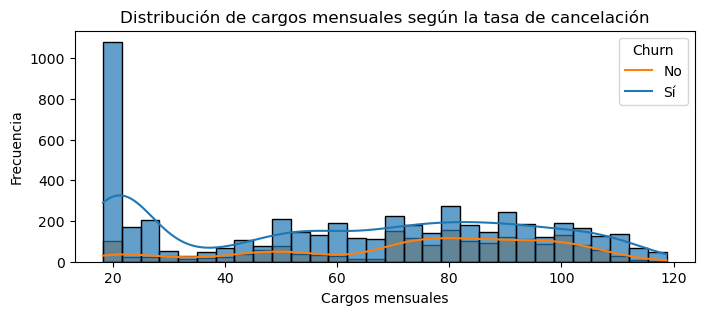

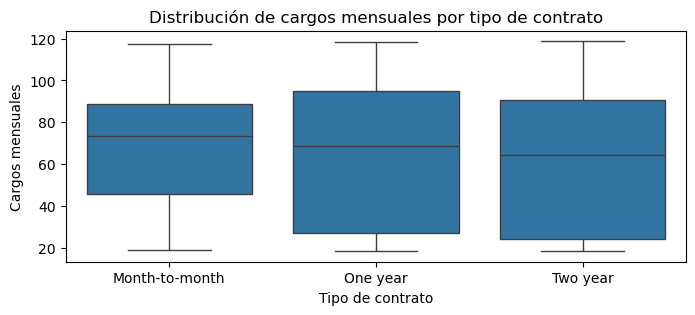

In [14]:
# Análisis de distribuciones condicionales
plt.figure(figsize=(8, 3))
sns.histplot(data=merged_data, x='MonthlyCharges', hue='Churn', bins=30, kde=True, alpha=0.7)
plt.title('Distribución de cargos mensuales según la tasa de cancelación')
plt.xlabel('Cargos mensuales')
plt.ylabel('Frecuencia')
plt.legend(title='Churn', labels=['No', 'Sí'])
plt.show()

plt.figure(figsize=(8, 3))
sns.boxplot(data=merged_data, x='Type', y='MonthlyCharges')
plt.title('Distribución de cargos mensuales por tipo de contrato')
plt.xlabel('Tipo de contrato')
plt.ylabel('Cargos mensuales')
plt.show()

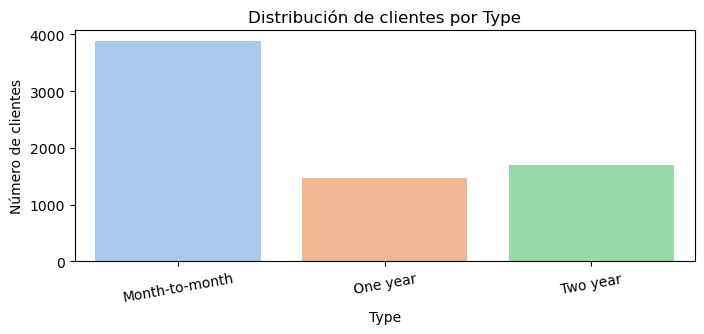

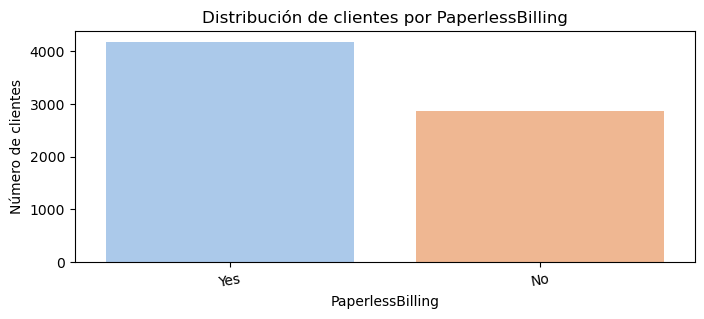

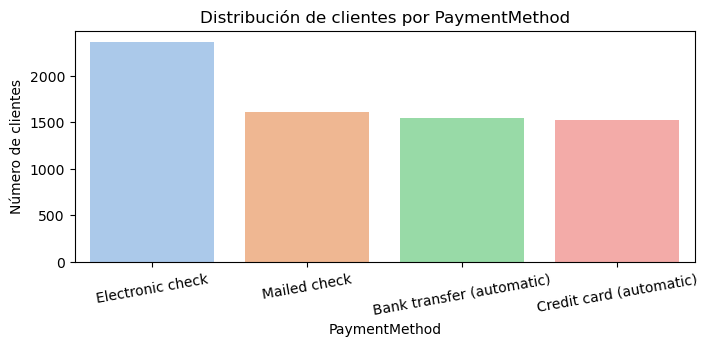

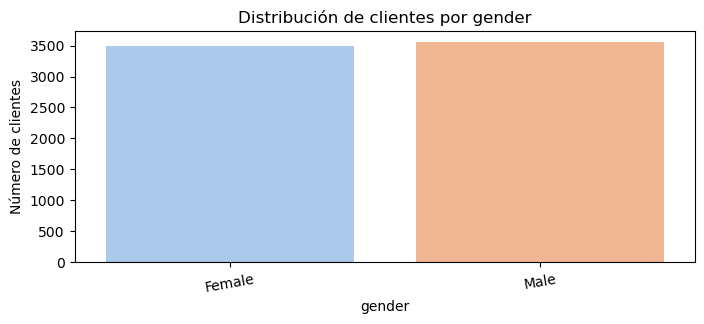

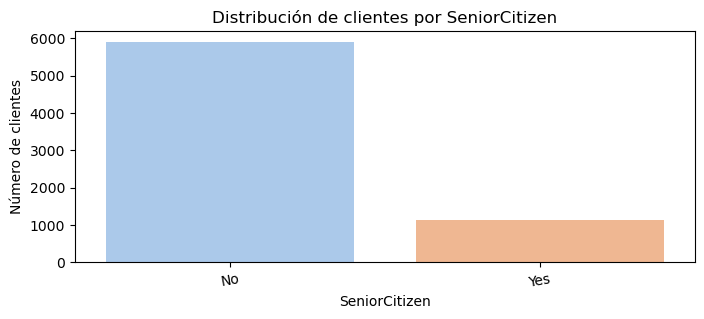

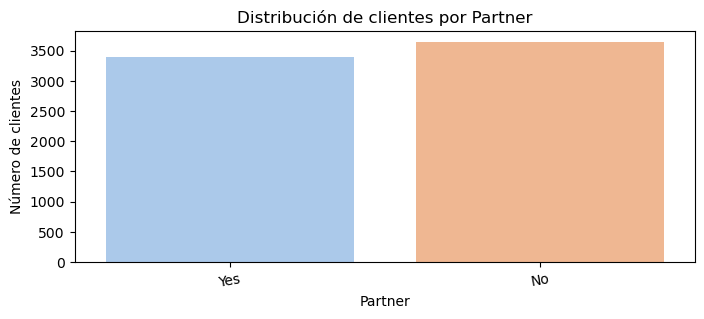

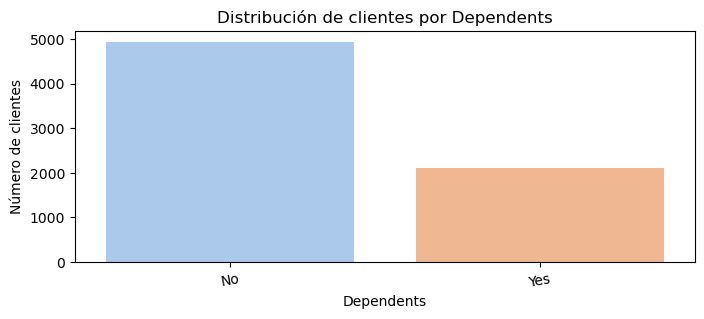

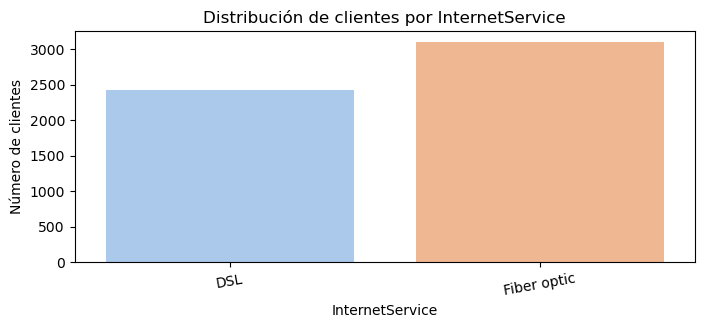

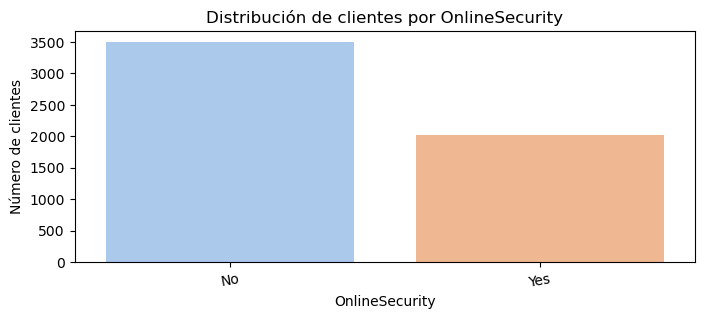

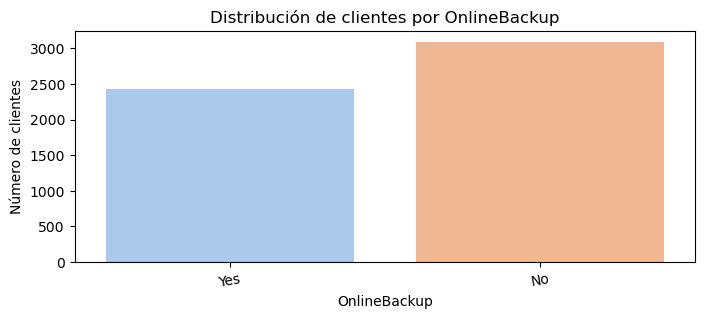

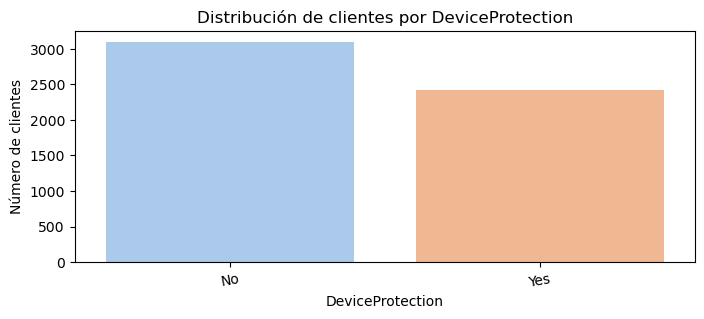

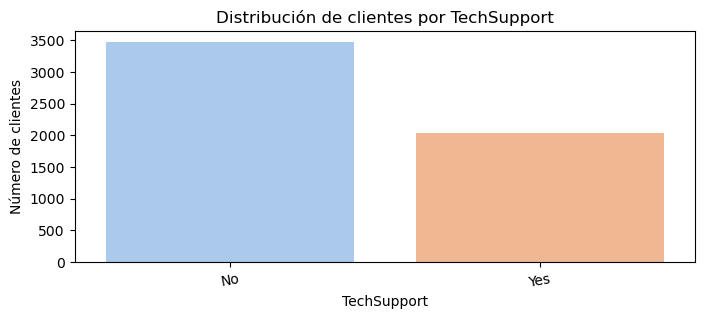

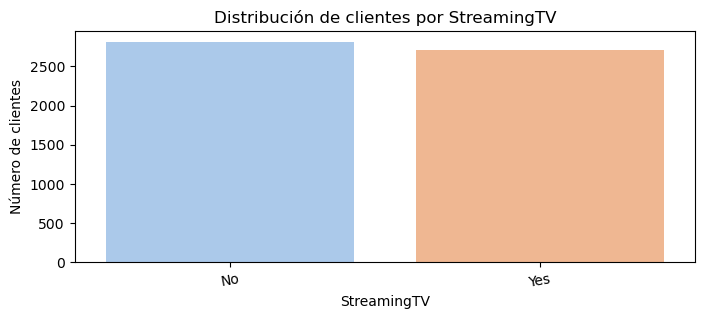

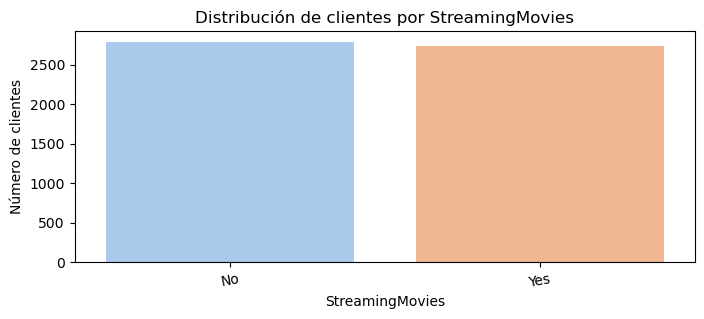

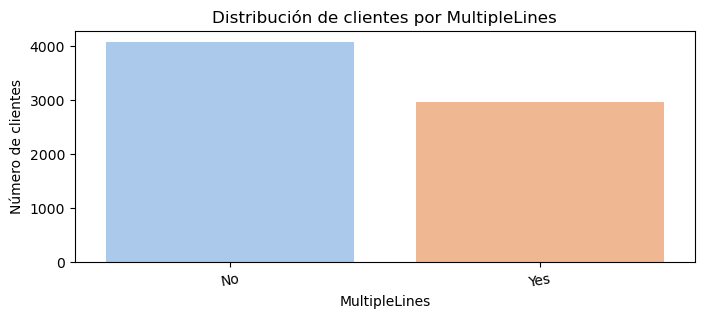

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definimos la función de visualización
def plot_categorical_distribution(data, column):
    plt.figure(figsize=(8, 3))
    sns.countplot(data=data, x=column, hue=column, palette='pastel', legend=False)
    plt.title(f'Distribución de clientes por {column}')
    plt.xlabel(column)
    plt.ylabel('Número de clientes')
    plt.xticks(rotation=10)
    plt.show()

# Lista de columnas categóricas
categorical_cols = [
    'Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
    'StreamingTV', 'StreamingMovies', 'MultipleLines'
]

# Generamos las gráficas
for col in categorical_cols:
    plot_categorical_distribution(merged_data, col)

**Visualización de características categóricas:**
Se muestran varios gráficos de barras que representan la distribución de clientes según diferentes características categóricas, como el tipo de contrato, el método de facturación electrónica, el método de pago, género, si tienen pareja, si tienen dependientes, el tipo de servicio de Internet y otros. Estos gráficos proporcionan una idea de la proporción de clientes en cada categoría, lo que puede ayudar a identificar posibles patrones o tendencias en la cancelación de clientes.

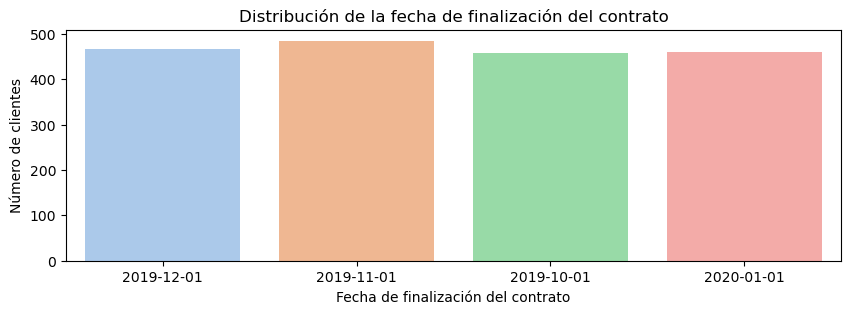

In [16]:
# Análisis de la variable objetivo
plt.figure(figsize=(10, 3))
sns.countplot(data=merged_data[merged_data['EndDate'] != today], x='EndDate', hue='EndDate', palette='pastel')
plt.title('Distribución de la fecha de finalización del contrato')
plt.xlabel('Fecha de finalización del contrato')
plt.ylabel('Número de clientes')
plt.xticks(rotation=0)
plt.show()

El gráfico de la variable objetivo muestra la distribución de la fecha de finalización del contrato para los clientes. En este caso, se ha filtrado para excluir aquellos clientes cuya fecha de finalización es igual al día de hoy, lo que indica que siguen siendo clientes activos.

A través de este gráfico, puedes visualizar cómo se distribuyen las finalizaciones de contrato a lo largo del tiempo, lo cual es importante para comprender la dinámica de la cancelación de clientes en diferentes períodos.

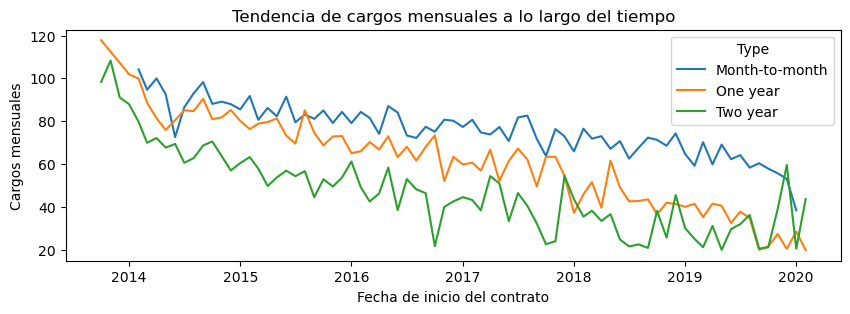

In [17]:
# Exploración de tendencias temporales
plt.figure(figsize=(10, 3))
sns.lineplot(data=merged_data, x='BeginDate', y='MonthlyCharges', hue='Type', errorbar=None)
plt.title('Tendencia de cargos mensuales a lo largo del tiempo')
plt.xlabel('Fecha de inicio del contrato')
plt.ylabel('Cargos mensuales')
plt.show()

El análisis del gráfico indica una tendencia general de disminución en los cargos mensuales a lo largo del tiempo para todos los tipos de contratos, lo que sugiere una reducción progresiva en los montos que los clientes pagan mensualmente. La línea azul, que representa los contratos mensuales, muestra la mayor variabilidad, evidenciando fluctuaciones más pronunciadas, posiblemente relacionadas con ajustes frecuentes en las tarifas o promociones temporales. En cambio, las líneas anaranjada (contratos de un año) y verde (contratos de dos años) también reflejan cambios en los cargos mensuales, aunque con menor variabilidad en comparación con los contratos mensuales, lo que podría indicar que los clientes con compromisos más largos experimentan ajustes en sus cargos con menos frecuencia.

In [ ]:
# Segmentación de clientes
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='MonthlyCharges', y='TotalCharges', hue='Type', alpha=0.5)
plt.title('Segmentación de clientes por cargos mensuales y cargos totales')
plt.xlabel('Cargos mensuales')
plt.ylabel('Cargos totales')
plt.show()

El gráfico muestra la segmentación de clientes en un diagrama de dispersión con tres tipos distintos de puntos, cada uno marcado con un color diferente.

Los puntos azules ("Month-to-month") se agrupan en la parte inferior del gráfico, formando una línea que sube en diagonal de izquierda a derecha. Esto sugiere que los clientes con contratos mensuales suelen tener cargos mensuales más bajos, pero acumulan un mayor cargo total con el tiempo, lo que podría reflejar una mayor tasa de rotación o menos compromiso a largo plazo.

Los puntos naranjas ("One year") y verdes ("Two year") también muestran una tendencia creciente, pero están distribuidos de forma más dispersa y cubren un rango vertical más amplio. Esto podría indicar que los clientes con contratos de uno o dos años tienen una mayor variedad en los cargos mensuales y totales, lo cual podría deberse a una diversidad en los planes y servicios que eligen dentro de estos contratos más extensos.

La densidad de puntos parece aumentar hacia la derecha del gráfico, lo cual podría sugerir un incremento en la cantidad de datos registrados en periodos recientes o en valores altos del eje horizontal. Esto podría estar relacionado con un aumento en los cargos mensuales o totales con el tiempo o con contratos más largos, sugiriendo una posible tendencia hacia una base de clientes más estable o consolidada a largo plazo

# 📊 Plan de Trabajo: Proyecto de Predicción de Cancelación de Clientes para Interconnect

---

## 🔍 Preguntas Iniciales

Para asegurar una comprensión completa y la alineación con los objetivos de Interconnect, es crucial resolver las siguientes cuestiones antes de comenzar:

1. **¿Cuáles son las fuentes originales de los datos y cómo se garantiza su actualización y precisión?**
   
3. **¿Qué estructura y significado tiene cada columna en los datos proporcionados?**  
   
4. **¿Qué otros datos externos o internos pueden complementar los datos actuales para mejorar la predicción de cancelación?**  

5. **¿Cuál es el flujo de trabajo planificado para usar los resultados del modelo en la práctica, especialmente para la retención de clientes?**  

6. **¿Existen hipótesis o patrones conocidos sobre los factores que influyen en la retención o cancelación de clientes?**  

7. **¿Cómo se evaluará el modelo en términos de precisión y aplicabilidad para cumplir con los objetivos de negocio?**  

---

## 🔄 Flujo de Trabajo Propuesto

### **Etapa 1: Definición y Planificación del Proyecto**
   - **Objetivo y Alcance**: Comprender las expectativas de Interconnect para traducir el objetivo en un problema de clasificación cuantificable, asegurando que la métrica AUC-ROC sea la principal y la precisión la secundaria.
   - **Planificación**: Definir cronogramas, roles y recursos necesarios para cumplir con cada etapa del proyecto.

### **Etapa 2: Recopilación y Consolidación de Datos**
   - **Obtención de Datos**: Reunir los archivos compartidos por Interconnect y validar su integridad.
   - **Unificación de Datos**: Integrar las distintas fuentes en un único dataset, utilizando `customerID` como clave única para fusionar la información de contrato, datos personales y servicios.

### **Etapa 3: Preparación de los Datos**
   - **Limpieza de Datos**:
     - Identificar y manejar valores ausentes, duplicados y anomalías para asegurar una base sólida para el análisis.
   - **Transformación de Datos**:
     - Estandarizar características numéricas y categóricas.
     - Crear variables adicionales que representen relaciones clave, como duración del contrato y método de pago.
   - **División del Conjunto de Datos**:
     - Dividir el dataset en entrenamiento, validación y prueba, asegurando que los datos de validación reflejen la temporalidad de los contratos.

### **Etapa 4: Análisis Exploratorio de Datos (EDA)**
   - **Exploración y Visualización**:
     - Identificar distribuciones y patrones de cancelación en diferentes segmentos de clientes.
   - **Evaluación de Correlaciones**:
     - Analizar relaciones significativas entre características y la probabilidad de cancelación.
   - **Selección de Variables**:
     - Identificar y conservar las variables más relevantes, eliminando aquellas que no agreguen valor predictivo.

### **Etapa 5: Modelado Predictivo**
   - **Prueba de Algoritmos**:
     - Implementar diversos algoritmos de clasificación como Random Forest, Gradient Boosting y Regresión Logística, entre otros.
   - **Optimización de Modelos**:
     - Usar validación cruzada y ajuste de hiperparámetros para maximizar el AUC-ROC.
     - Aplicar técnicas de balance de clases (e.g., SMOTE) si los datos están desbalanceados.
   - **Selección de Modelo Final**:
     - Identificar el modelo con mejor rendimiento (AUC-ROC y precisión) en los conjuntos de validación y prueba.

### **Etapa 6: Implementación y Automatización del Modelo**
   - **Modelo Final**:
     - Entrenar el modelo seleccionado en el conjunto de entrenamiento completo y evaluar su rendimiento final en el conjunto de prueba.
   - **Automatización**:
     - Configurar un pipeline automatizado para procesamiento de datos y generación de predicciones.
   - **Documentación Técnica**:
     - Documentar el proceso de entrenamiento y preparación del modelo para facilitar su implementación en producción.

### **Etapa 7: Presentación y Aplicación de Resultados**
   - **Informe Ejecutivo**:
     - Crear un resumen de los resultados clave, incluyendo la métrica AUC-ROC alcanzada y el impacto esperado.
   - **Visualización de Métricas y Curvas**:
     - Presentar gráficos detallados como la curva AUC-ROC y otras visualizaciones para demostrar la efectividad del modelo.
   - **Recomendaciones para Retención de Clientes**:
     - Sugerir estrategias de retención al equipo de marketing de Interconnect, basadas en los patrones identificados y las predicciones del modelo.

---

Este plan está diseñado para maximizar el impacto del proyecto de predicción de cancelación, proporcionando a Interconnect las herramientas necesarias para identificar clientes en riesgo y aplicar estrategias de retención de manera efectiva.
